In [162]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
import torch


In [2]:
from datetime import datetime, timedelta



In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:8737]    

<class 'numpy.ndarray'>


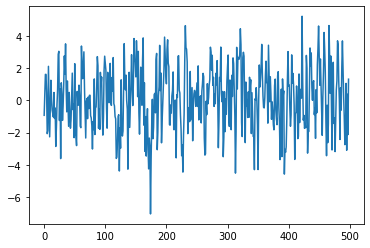

In [216]:
# make the data
n = 8736 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
    

eta = np.random.normal(0, 1, n)
rho = [0.45, -0.25, 0.25]
beta = [1.00, -1.00]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-24] + rho[2]*y[i-168] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

     
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [217]:
df = pd.DataFrame(X, columns=['a1', 'a2'])
df['hours'] = hours
df['y'] = y

In [226]:
mod = ARMA(
        regressor_col=['a1', 'a2'],
        lm_first=0,
        estimator='stan-mcmc',
        date_col = 'hours',
        response_col = 'y',
        num_of_ar_lags = 3,
        ar_lags = [1,24,168],
        num_of_ma_lags = 1,
        ma_lags = [1] ,

)

In [ ]:
mod.fit(df)


Gradient evaluation took 0.016308 seconds
1000 transitions using 10 leapfrog steps per transition would take 163.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.017135 seconds
1000 transitions using 10 leapfrog steps per transition would take 171.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.017112 seconds
1000 transitions using 10 leapfrog steps per transition would take 171.12 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.019745 seconds
1000 transitions using 10 leapfrog steps per transition would take 197.45 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Wa

In [ ]:
pred = mod.predict(df)

TypeError: 'NoneType' object is not callable

In [204]:
mod.

6.162777300461799

In [205]:
mod.get_regression_coefs

functools.partial(<bound method ARMAModel.get_regression_coefs of <orbit.template.arma.ARMAModel object at 0x13f0dddd0>>, {'response': array([-0.49195402, -0.74449427, -1.04497514, ..., -1.67659986,
       -0.77035228, -1.50182589]), 'date_array': 0      2021-01-01 00:00:00
1      2021-01-01 01:00:00
2      2021-01-01 02:00:00
3      2021-01-01 03:00:00
4      2021-01-01 04:00:00
               ...        
8731   2021-12-30 19:00:00
8732   2021-12-30 20:00:00
8733   2021-12-30 21:00:00
8734   2021-12-30 22:00:00
8735   2021-12-30 23:00:00
Name: hours, Length: 8736, dtype: datetime64[ns], 'num_of_obs': 8736, 'response_sd': 6.162777300461799, 'training_start': '2021-01-01 00:00', 'training_end': '2021-12-30 23:00', 'date_col': 'hours', 'response_col': 'y'}, None, {'mean': {'obs_sigma': array([0.99632939]), 'mu': array([0.00118954]), 'rho': array([[0.98720912]])}, 'median': {'obs_sigma': array([0.99656385]), 'mu': array([0.00083361]), 'rho': array([[0.9870284]])}}, OrderedDict([('obs_sigm